In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
from pyha import *
from pyha.cores import *
from pyha.cores.util import *
import scipy
from scipy import signal
import warnings
warnings.filterwarnings('ignore') # yolo!
import numpy as np

# GitHub cannot display the Table of Contents!

<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Info
Combines multiple Pyha cores to calculate a spectrogram with average pooling feature. See individual components for more info.

# Examples

INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 139264/139264 [01:47<00:00, 1292.32it/s]
INFO:sim:Flushing the pipeline to collect 8704 valid samples (currently have 8576)
INFO:sim:Hardware delay is 1190


<IPython.core.display.Javascript object>


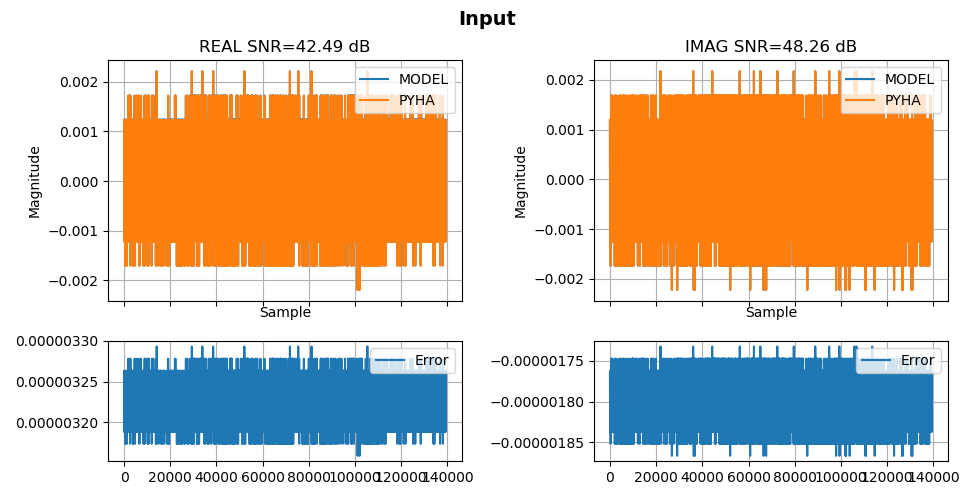

<IPython.core.display.Javascript object>


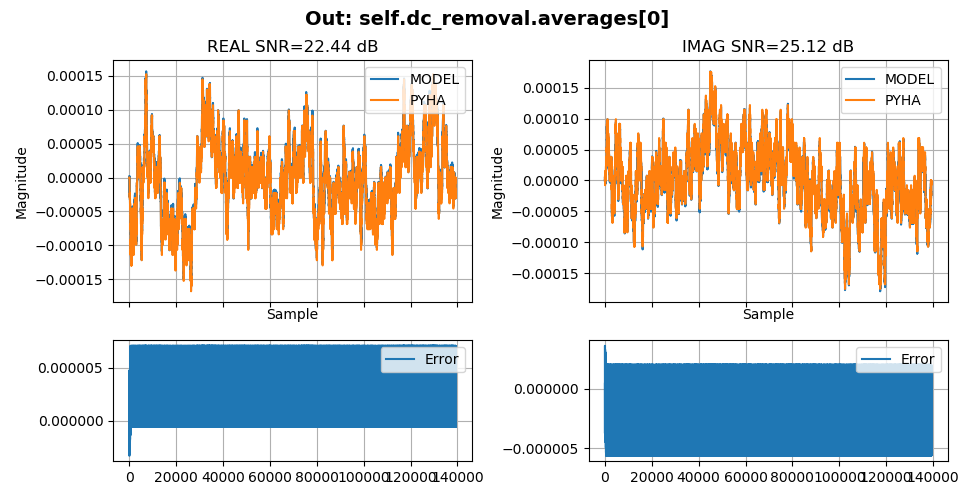

<IPython.core.display.Javascript object>


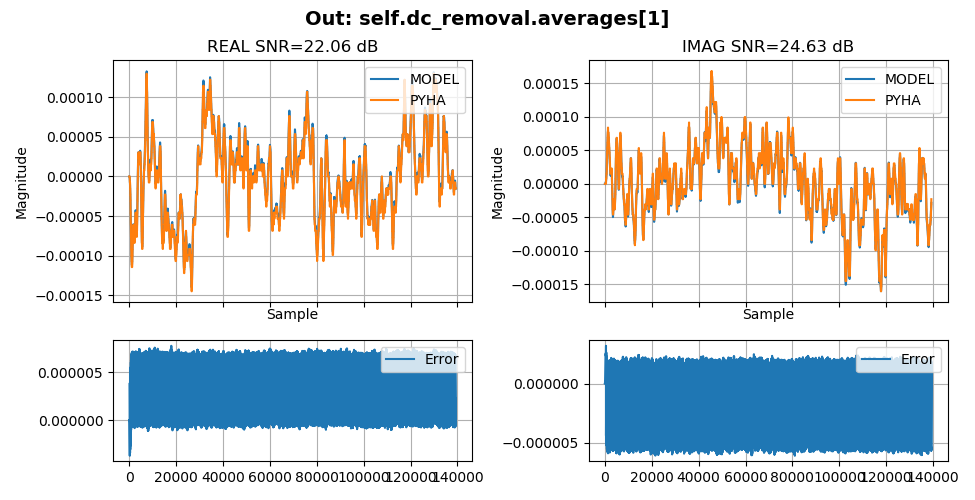

<IPython.core.display.Javascript object>


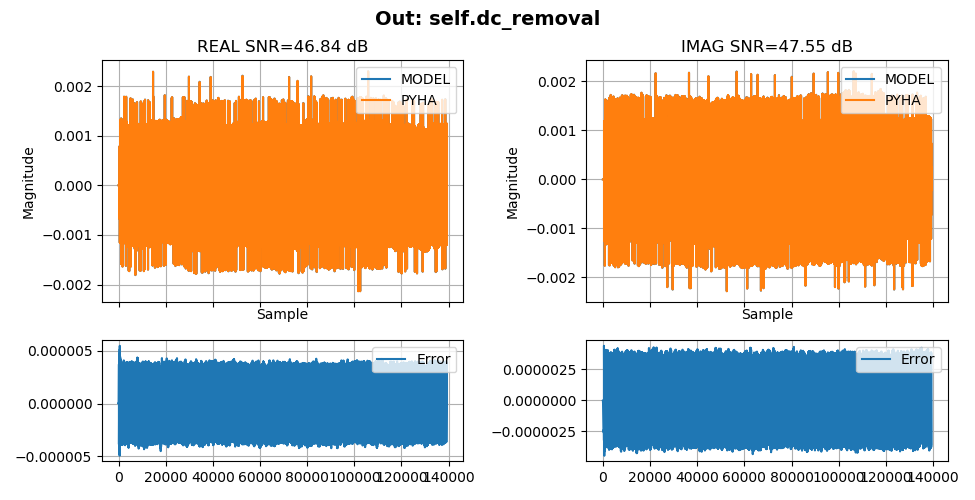

<IPython.core.display.Javascript object>


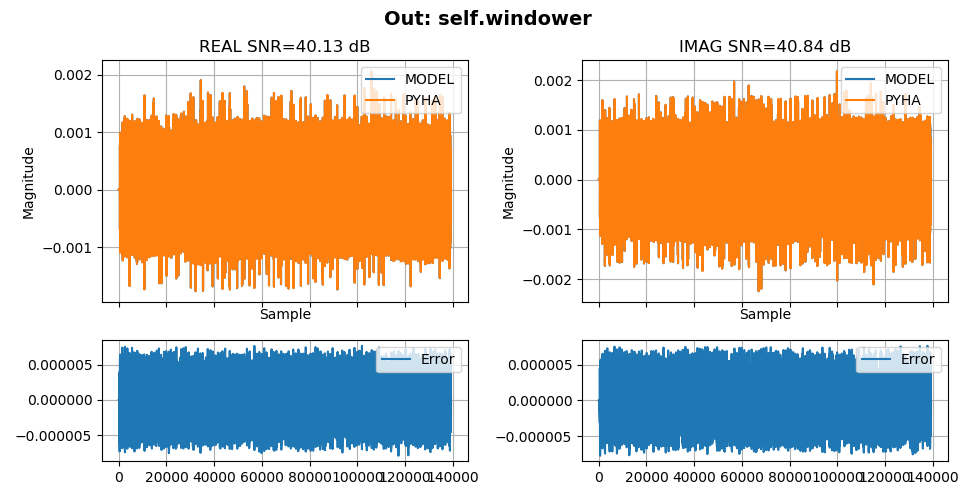

<IPython.core.display.Javascript object>


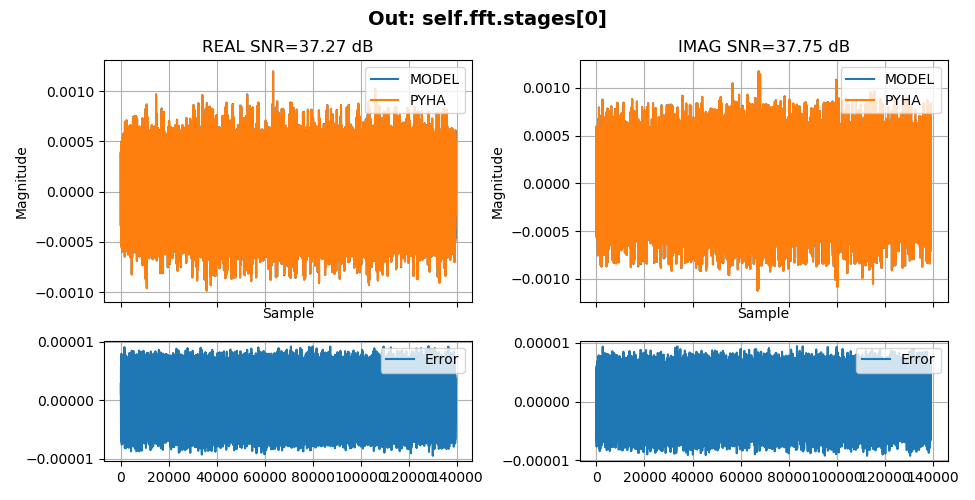

<IPython.core.display.Javascript object>


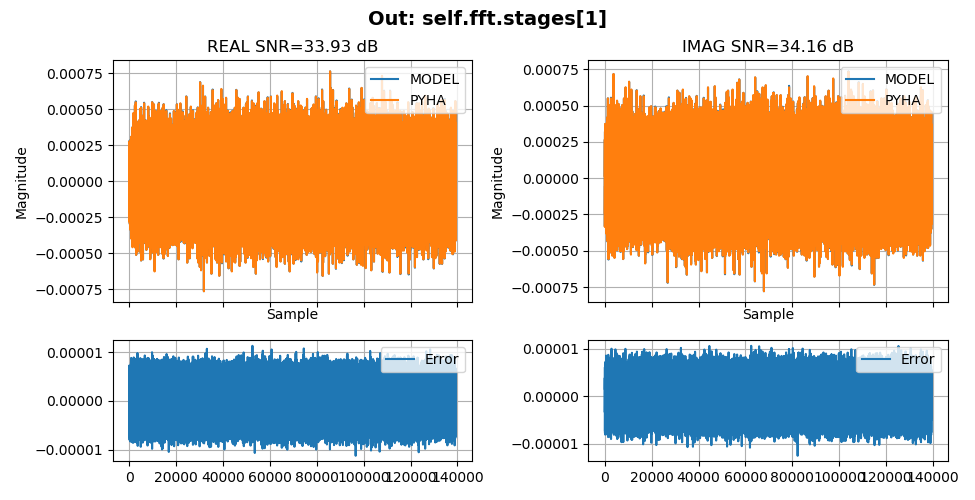

<IPython.core.display.Javascript object>


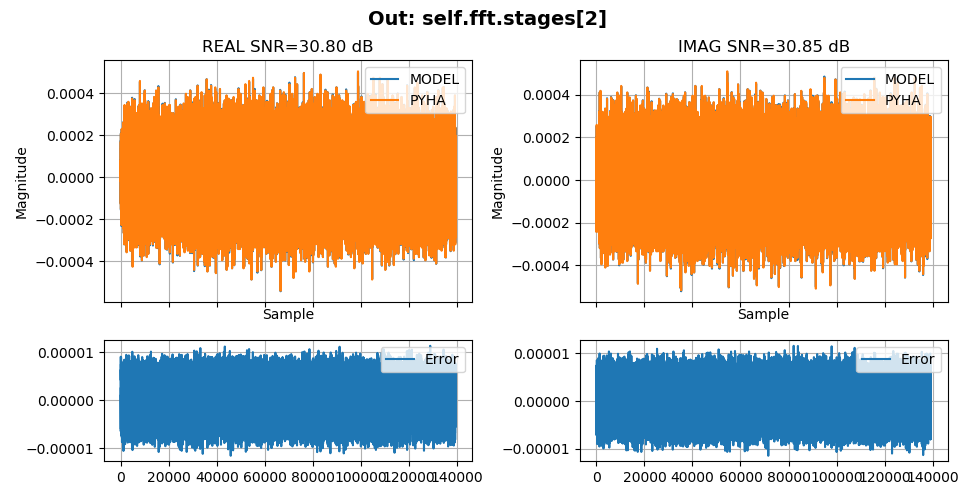

<IPython.core.display.Javascript object>


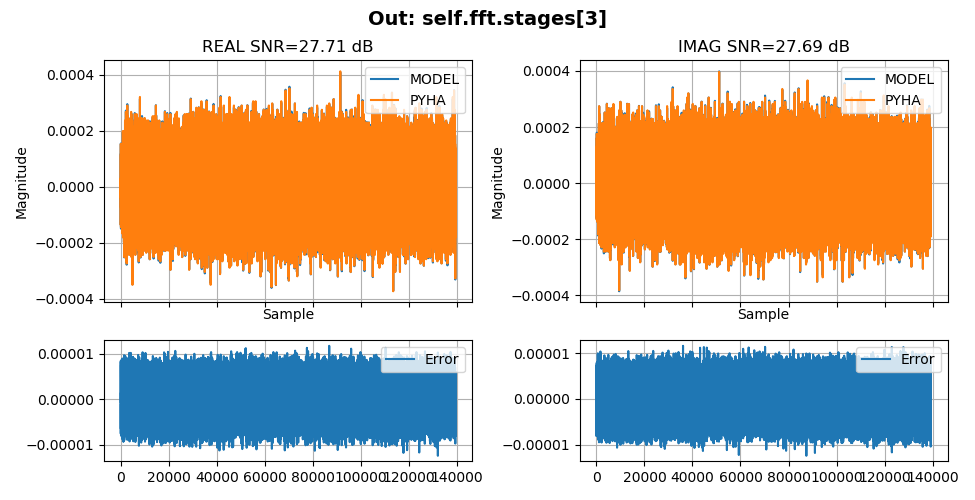

<IPython.core.display.Javascript object>


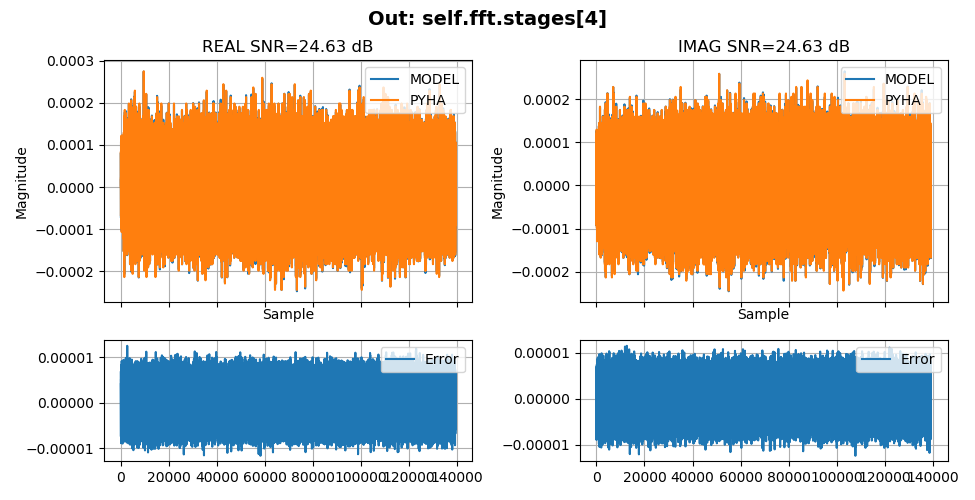

<IPython.core.display.Javascript object>


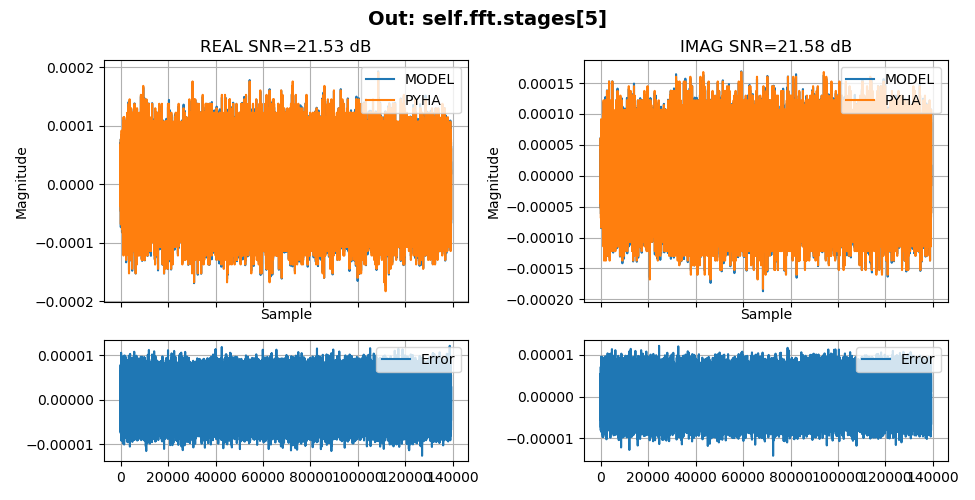

<IPython.core.display.Javascript object>


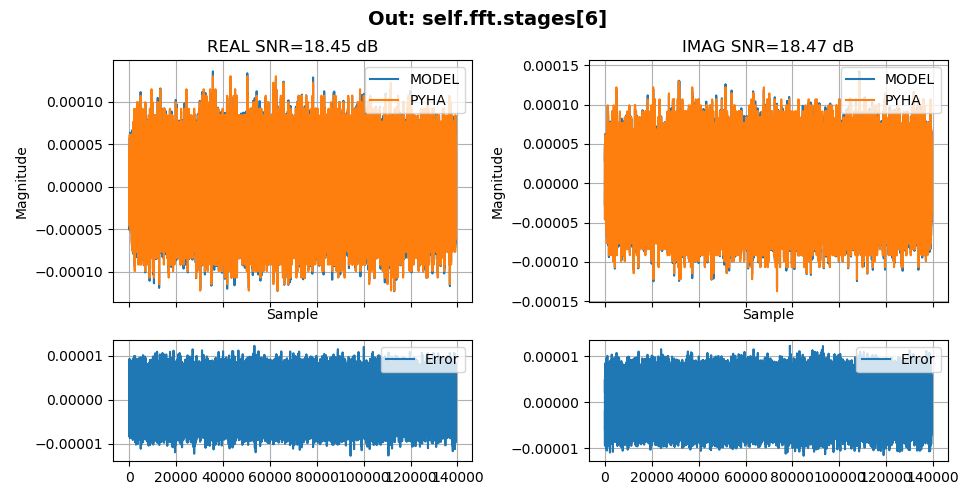

<IPython.core.display.Javascript object>


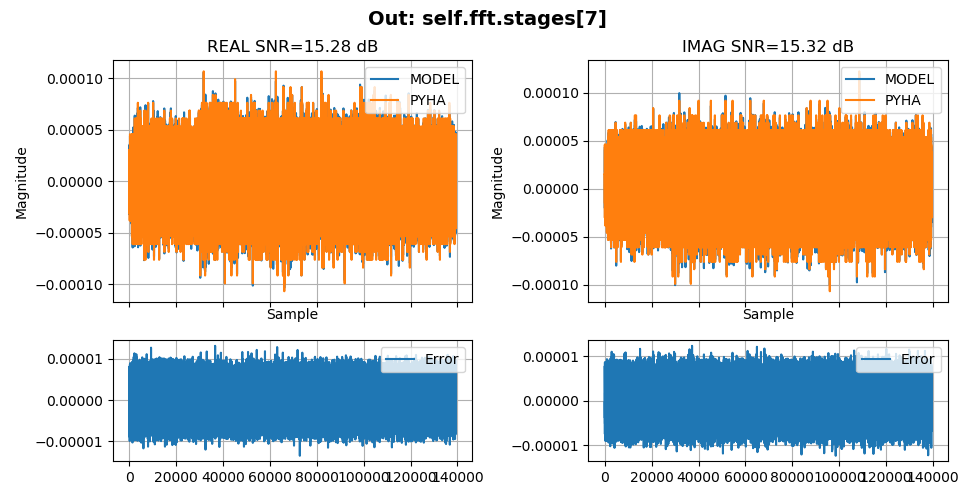

<IPython.core.display.Javascript object>


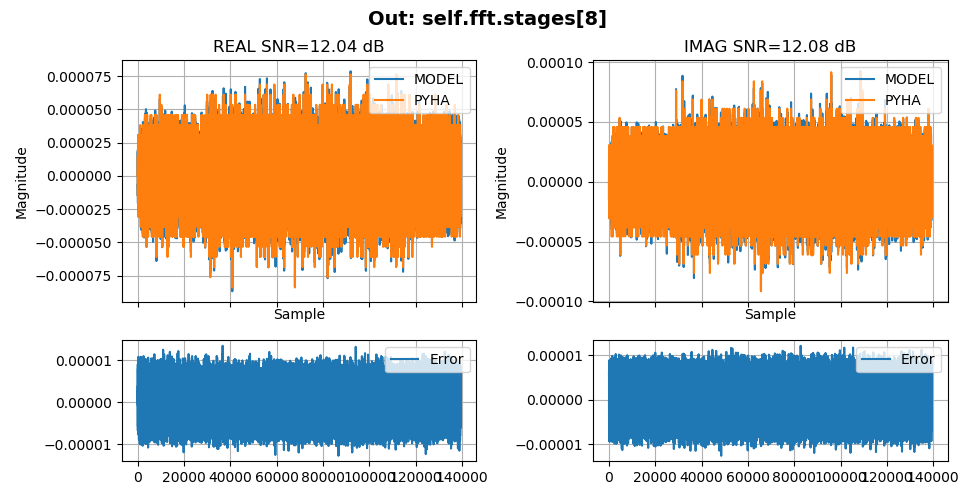

<IPython.core.display.Javascript object>


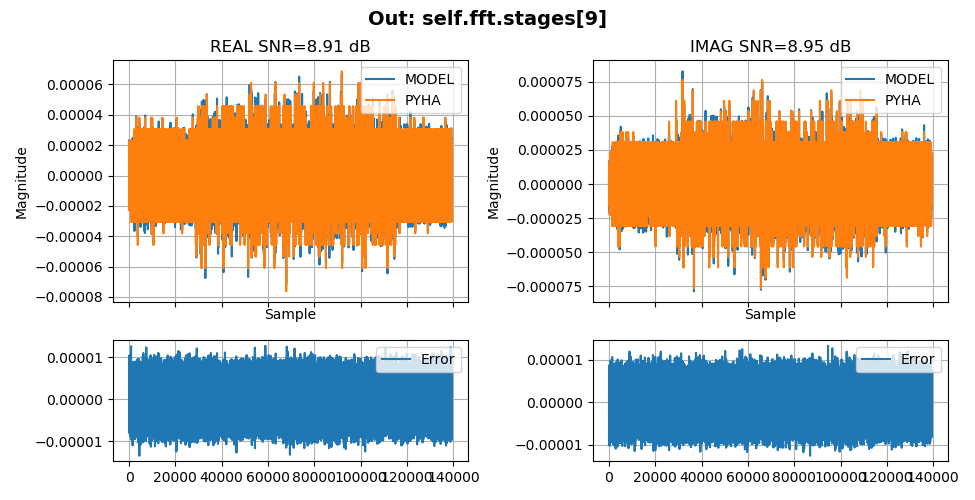

<IPython.core.display.Javascript object>


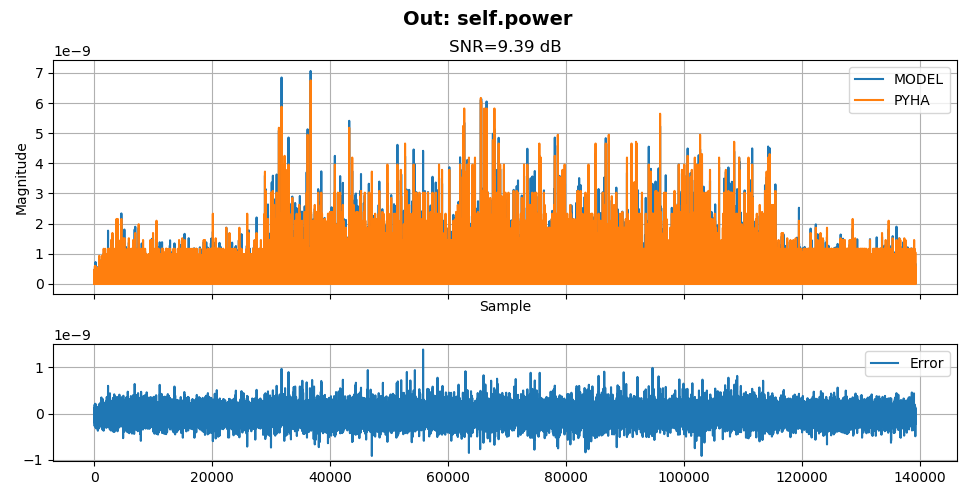

<IPython.core.display.Javascript object>


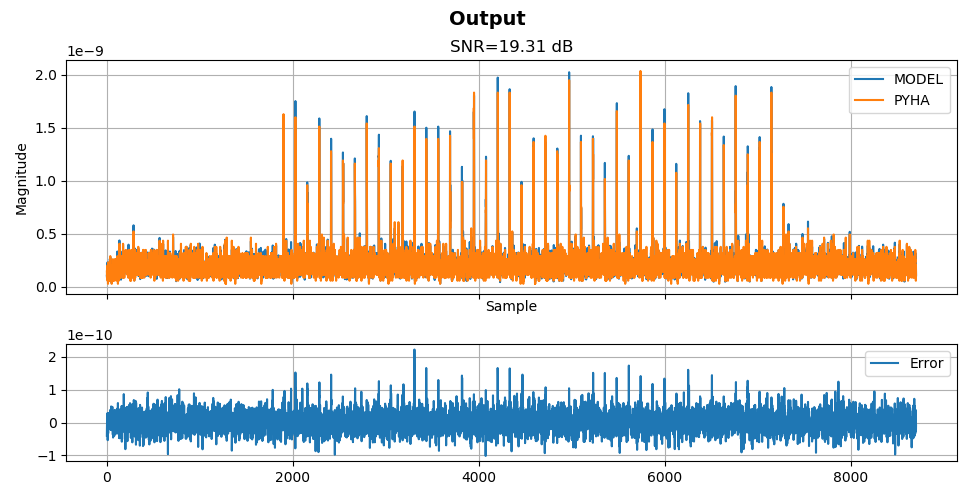

In [3]:
file = get_data_file('phantom3_low_power_bladerf.complex64')
input_signal = load_complex64_file(file)

fft_size = 1024
avg_freq_axis = 8
avg_time_axis = 2
dut = Spectrogram(fft_size, avg_freq_axis, avg_time_axis)
sims = Simulator(dut, trace=True).run(input_signal) # run simulations and gather trace
sims.plot_trace()

<IPython.core.display.Javascript object>


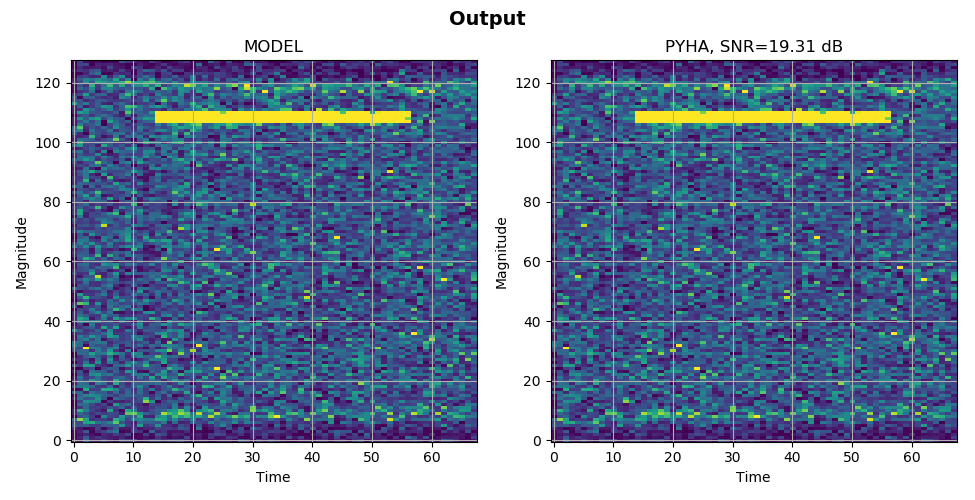

In [4]:
sims.plot_trace(mode={'Input': None, 'Output': 'imshow'}, rows=len(input_signal) // fft_size // avg_time_axis, transpose=True, inout_only=True)

# Conversion to VHDL and RTL/NETLIST simulations

In [5]:
# Pyha design can be converted to VHDL after the PYHA simulation has been ran
# VHDL sources can be used to run the RTL simulation, in addition NETLIST simulation is supported (after Quartus mapper)
# Pyha automatically manages everything needed if you specify the 'RTL', 'NETLIST' flags.
output_dir = '~/Documents/pyha_output'
dut = Spectrogram(fft_size, avg_freq_axis, avg_time_axis, fft_twiddle_bits=9, window_bits=8)
vhdl_sim = Simulator(dut, output_dir=output_dir, extra_simulations=['RTL', 'NETLIST']).run(input_signal[:fft_size*avg_time_axis*2])
vhdl_sim.assert_equal(atol=1e-3, rtol=1e-3)

INFO:sim:Simulaton needs to support conversion to VHDL -> major slowdown
INFO:sim:Running "MODEL" simulation...
INFO:sim:Running "PYHA" simulation...
100%|██████████| 4096/4096 [00:16<00:00, 253.05it/s]
INFO:sim:Flushing the pipeline to collect 256 valid samples (currently have 128)
INFO:sim:Hardware delay is 1190
INFO:conversion:Creating top.vhd ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:DataValid to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:MovingAverage to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DCRemoval to VHDL ...
INFO:conversion:Windower to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conversion:ShiftRegister to VHDL ...
INFO:conversion:DownCounter to VHDL ...
INFO:conversion:StageR2SDF to VHDL ...
INFO:conv

# Synthesis:  resource usage and Fmax

In [6]:
print(vhdl_sim.quartus.get_resource_usage('fit'))
print(vhdl_sim.quartus.get_fmax())

INFO:synth:Running quartus_fit quartus_project...
/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory
INFO:synth:Running quartus_sta -t script.tcl...


Family : Cyclone IV E
Device : EP4CE40F23C8
Timing Models : Final
Total logic elements : 4,945 / 39,600 ( 12 % )
    Total combinational functions : 4,652 / 39,600 ( 12 % )
    Dedicated logic registers : 2,301 / 39,600 ( 6 % )
Total registers : 2301
Total pins : 76 / 329 ( 23 % )
Total virtual pins : 0
Total memory bits : 82,044 / 1,161,216 ( 7 % )
Embedded Multiplier 9-bit elements : 80 / 232 ( 34 % )
Total PLLs : 0 / 4 ( 0 % )



/quartus/adm/qenv.sh: line 83: warning: setlocale: LC_CTYPE: cannot change locale (en_US.UTF-8): No such file or directory


+-------------------------------------------------+
; Fmax Summary                                    ;
+-----------+-----------------+------------+------+
; Fmax      ; Restricted Fmax ; Clock Name ; Note ;
+-----------+-----------------+------------+------+
; 73.98 MHz ; 73.98 MHz       ; clk        ;      ;
+-----------+-----------------+------------+------+
This panel reports FMAX for every clock in the design, regardless of the user-specified clock periods.  FMAX is only computed for paths where the source and destination registers or ports are driven by the same clock.  Paths of different clocks, including generated clocks, are ignored.  For paths between a clock and its inversion, FMAX is computed as if the rising and falling edges are scaled along with FMAX, such that the duty cycle (in terms of a percentage) is maintained. Altera recommends that you always use clock constraints and other slack reports for sign-off analysis.



In [7]:
# 1024 dut = Spectrogram(fft_size, avg_freq_axis=16, avg_time_axis=1, fft_twiddle_bits=9, window_bits=8)
# INFO:sim:Total logic elements : 5,117
# INFO:sim:    Total combinational functions : 4,820
# INFO:sim:    Dedicated logic registers : 2,514
# INFO:sim:Total registers : 2514
# INFO:sim:Total pins : 78
# INFO:sim:Total virtual pins : 0
# INFO:sim:Total memory bits : 59,004
# INFO:sim:Embedded Multiplier 9-bit elements : 80

# dut = Spectrogram(fft_size, avg_freq_axis=8, avg_time_axis=1, fft_twiddle_bits=9, window_bits=8)
# INFO:sim:Family : Cyclone IV E
# INFO:sim:Total logic elements : 5,125
# INFO:sim:    Total combinational functions : 4,829
# INFO:sim:    Dedicated logic registers : 2,519
# INFO:sim:Total registers : 2519
# INFO:sim:Total pins : 78
# INFO:sim:Total virtual pins : 0
# INFO:sim:Total memory bits : 63,612
# INFO:sim:Embedded Multiplier 9-bit elements : 80

In [8]:
# INFO:sim:Family : Cyclone IV E
# INFO:sim:Total logic elements : 10,821
# INFO:sim:    Total combinational functions : 10,527
# INFO:sim:    Dedicated logic registers : 3,171
# INFO:sim:Total registers : 3171
# INFO:sim:Total pins : 78
# INFO:sim:Total virtual pins : 0
# INFO:sim:Total memory bits : 607,140
# INFO:sim:Embedded Multiplier 9-bit elements : 104